# Introduction

You should have a database created from pasing one of the zip files hosted by HHS.



In [1]:
from sqlalchemy import engine_from_config, func
from sqlalchemy.orm import sessionmaker
from hornstone.alchemy import Base
import us
from revaers.models import Data, VaxData
from revaers.parser import parse_csv
from revaers.parser import parse_csvfile
from revaers.parser import parse_vaxfile

import numpy as np
import plotly.io as pio
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf

plt.style.use('dark_background')



In [2]:

dburl = 'postgresql+psycopg2://dbadmin@localhost/revaers'
settings = {'sqlalchemy.url': dburl}
engine = engine_from_config(settings)
Base.metadata.create_all(engine)
Session = sessionmaker()
Session.configure(bind=engine)


In [3]:
s = Session()


In [4]:
s.query(Data).count()


146853

In [5]:

def make_data_frame(query):
    return pd.read_sql(query.statement, query.session.bind)


In [6]:

query = s.query(Data, VaxData).join(VaxData)
cvquery = query.filter(VaxData.vax_type == 'COVID19')
# .filter(Data.died == True)
msquery = cvquery.filter(Data.state == 'MS')
dtquery = s.query(Data.recvdate, func.count(Data.vaers_id)).group_by(Data.recvdate).order_by(Data.recvdate)

df = make_data_frame(cvquery)
df[['vax_manu', 'recvdate']].groupby('recvdate')['vax_manu']

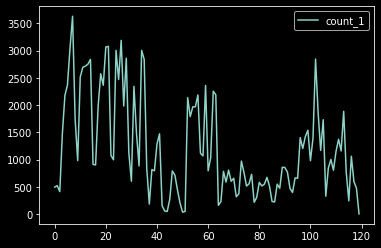

In [7]:
df = make_data_frame(dtquery)
df.plot()


In [8]:
df.head().age_yrs.plot.bar()

AttributeError: 'DataFrame' object has no attribute 'age_yrs'

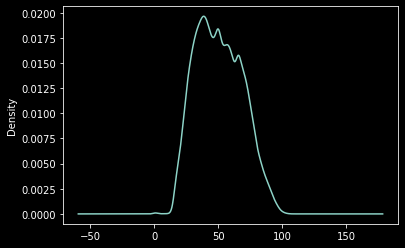

In [9]:
q = s.query(Data, VaxData).join(VaxData)
q = q.filter(VaxData.vax_type == 'COVID19')
#.filter(Data.died == True)
#query = query.filter(Data.state == 'MS')
# q = q.filter(Data.age_yrs < 64).filter(Data.age_yrs > 0)
dq = q.filter(Data.died == True)
df = make_data_frame(q)
df
df.age_yrs.plot.kde()


In [10]:
ev = df[['vaers_id', 'recvdate']].groupby('recvdate').count()
ev.vaers_id.max()

vaers_id    3606
vaers_id    3606
dtype: int64

In [11]:
# df.groupby(df.recvdate.dt.isocalendar().week)['vaers_id'].count()


In [12]:
df.groupby('vax_manu').count()


,vaers_id,recvdate,state,age_yrs,cage_yr,cage_mo,sex,rpt_date,symptom_text,died,...,timespan,bad_dates,questionable,vaers_id,vax_type,vax_lot,vax_dose_series,vax_route,vax_site,vax_name
vax_manu,,,,,,,,,,,,,,,,,,,,,
JANSSEN,29312,29312,29312,24385,22068,29312,29312,0,29312,29312,...,207,29312,29312,29312,29312,29312,29312,29312,29312,29312
MODERNA,64645,64645,64645,60726,60633,64645,64645,66,64645,64645,...,1713,64645,64645,64645,64645,64645,64645,64645,64645,64645
PFIZER\BIONTECH,52003,52003,52003,46278,35040,52003,52003,33,52003,52003,...,1440,52003,52003,52003,52003,52003,52003,52003,52003,52003
UNKNOWN MANUFACTURER,484,484,484,337,279,484,484,1,484,484,...,16,484,484,484,484,484,484,484,484,484


In [13]:
modq = cvquery.filter(VaxData.vax_manu == 'MODERNA')
pfq = cvquery.filter(VaxData.vax_manu == 'PFIZER\BIONTECH')
jjq = cvquery.filter(VaxData.vax_manu == 'JANSSEN')

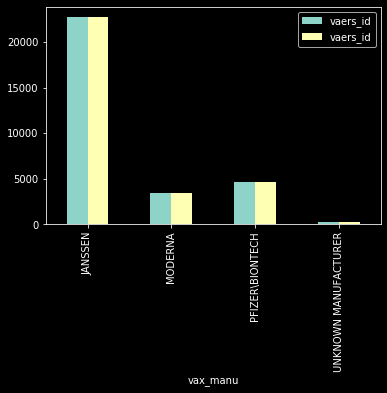

In [14]:
df = make_data_frame(jjq)
df
q = cvquery.filter(Data.recvdate >= '2021-04-01')
df = make_data_frame(q)
cdf = df[['vaers_id', 'vax_manu']].groupby('vax_manu').count()

cdf.plot.bar()
